## Normality testing
I looked a bit into the topic, as I wanted to know if I can just blatantly say "the data seems to be normal," and continue using methods used for normal data. This is by no means supposed to be a statistics lesson but more so what I got out of looking into the topic:

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from sqlite3_funcs import sqlite_to_df
from data_processing_funcs import different_bin_counts

plt.rcParams["figure.figsize"]=(16,8)

DB_PATH = "fired_shots.db"

Let's start with familiar data from `shot_grouping.ipynb`. 


!!

This assumes `shot_grouping.ipynb` has been run as a whole once, and AXMC data at `DB_PATH` has been already fixed! 

!!

*(the faulty values are still in the original files of* `fired shots.sqf`*-folder)*

 First, let's create the DataFrames the same way before

In [8]:
dfs = {}            # The actual dataframes based on the query
bin_cnts = {}       # Histogram bin counts per each df

firing_range = 1100

for weap_short in ["axmc", "m110", "m200", "m2010"]:
    
    # Note the firing_range is sepcified here, too.
    
    # data_batch is selected for tracking potential issues
    q = f'''
    SELECT id, x, y, dist_from_mean, data_batch
    FROM shots
    WHERE (weap_short = "{weap_short}" AND firing_range = {firing_range})
    '''
    dfs[weap_short] = sqlite_to_df(q, DB_PATH)
    
    bin_cnts[weap_short] = different_bin_counts(dfs[weap_short]["dist_from_mean"].to_numpy())
    
    print(dfs[weap_short].shape)

(1872, 5)
(3995, 5)
(14017, 5)
(2015, 5)


Moving on, let's print the colored KDEs & dashed standard normal distributions to the first figure, to get some visual *feel*.

In the second figure, I decided to compare the p-values with different sample sizes of Shapiro-Wilk test. This certainly isn't a scientific study, but as of the edit on January 24, 2021, Nick Cox [stated the following](https://stats.stackexchange.com/questions/446262/can-a-sample-larger-than-5-000-data-points-be-tested-for-normality-using-shapiro):

> I can't comment on why that particular function  (*`shapiro.test()` in R*)  won't perform, but the larger question is why you are doing this kind of testing at all. A good reason not to care is generic: for sample sizes of that order, or even larger, such tests are arguably fairly useless as even minute deviations from normality will qualify as significant at conventional levels. More specifically: why is it important or interesting to test for normality? People often apply such tests to marginal distributions given a widespread myth that marginal normality is a requirement for very many procedures. Where normality is a relevant assumption, or ideal condition, it usually applies to distributions conditional on a structure of mean outcomes or responses.

His comment among others encouraged me that a normality test may not even be particularly useful here.

axmc
standardized x kurt test  -0.283893178187812
standardized x skew test  0.0061867533473569285
standardized x shapiro-wilk test  0.03045906312763691
m110
standardized x kurt test  -0.1291177996744568
standardized x skew test  -0.023941210902213843
standardized x shapiro-wilk test  0.3994493782520294
m200
standardized x kurt test  -0.2666820026089214
standardized x skew test  -0.011629344218961824
standardized x shapiro-wilk test  5.484318776893815e-08


C:\Users\Ari\anaconda3\envs\dataml100\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


m2010
standardized x kurt test  -0.42005249566863023
standardized x skew test  -0.05195346890477445
standardized x shapiro-wilk test  0.0004030897398479283


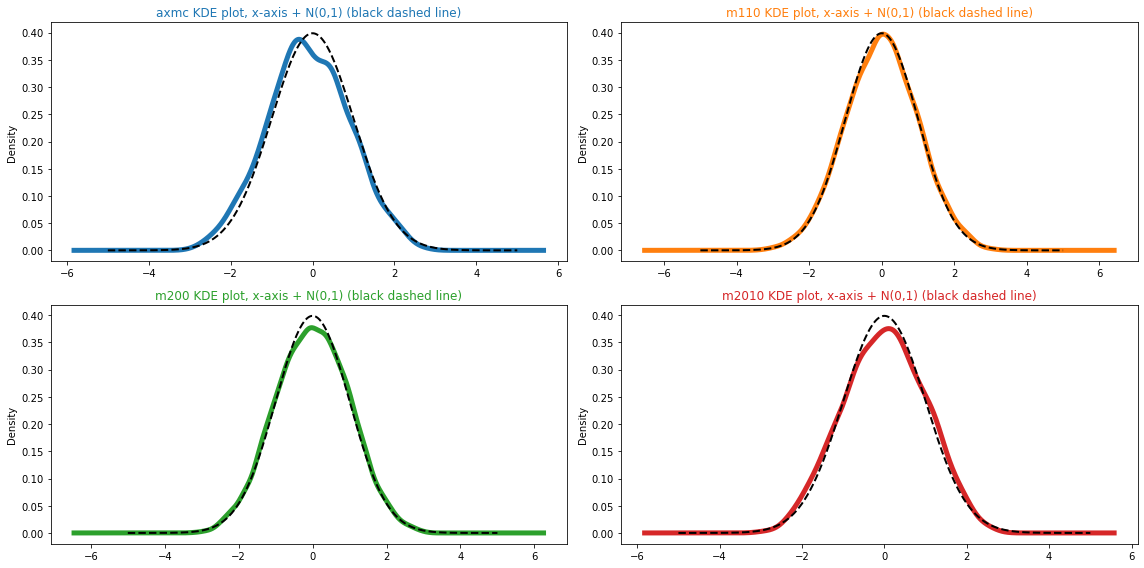

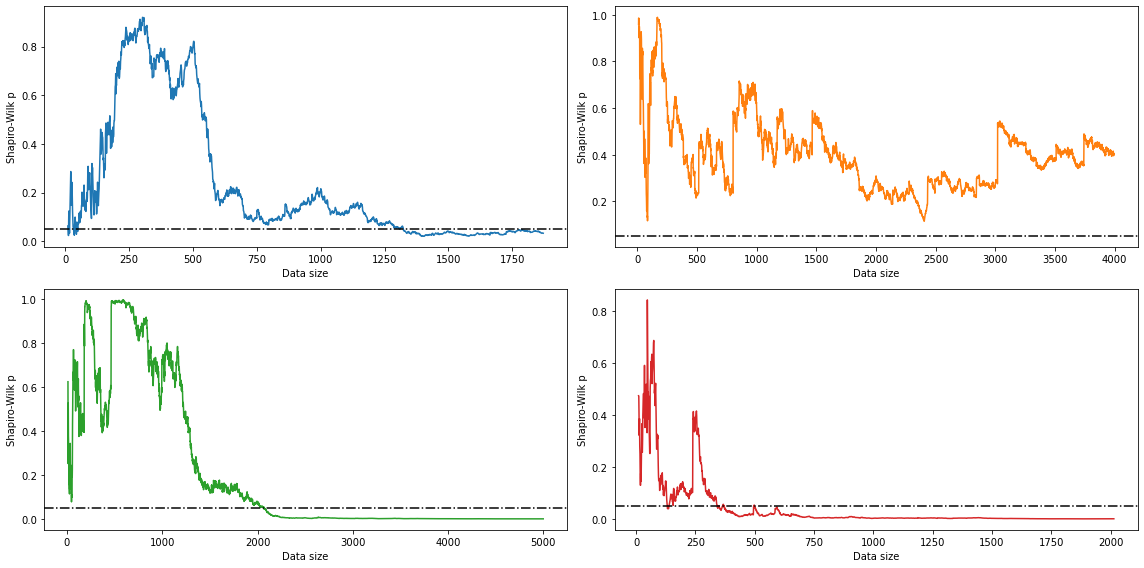

In [14]:
# x QQ-plot, y QQ-plot, histogram
figx, axsx = plt.subplots(tight_layout=True,nrows=2,ncols=2)
figx_sw, axsx_sw_test = plt.subplots(tight_layout=True,nrows=2,ncols=2)


for i, (weap_short, axx_i, axx_sw_i) in enumerate(zip(dfs, axsx.flatten(), axsx_sw_test.flatten())):
    
    # The x and y values are half way towards standardization: 
    # They still must be divided with their standard deviation
    
    # norm. distr. z-value; mean is already 0, hence only div by std
    # z_x = dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"])
    # z_y = dfs[weap_short]["y"]/np.std(dfs[weap_short]["y"])
    
    
    # Plot a density plot of standardized x and y (mu=0, sigma=1)
    (dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"])).plot.density(ax=axx_i, c=f"C{i}", linewidth=5)
    
    x = np.linspace(-5,5,1000)
    std_norm_distr = stats.norm.pdf(x,0,1)
  
    axx_i.plot(x,std_norm_distr, linewidth=2, c="k", ls="--")

    
    axx_i.set_title(f"{weap_short} KDE plot, x-axis + N(0,1) (black dashed line)", c=f"C{i}")#, position=[0,0])

    print(weap_short)
    print("standardized x kurt test ", stats.kurtosis(dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"])))
    print("standardized x skew test ", stats.skew(dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"])))
    print("standardized x shapiro-wilk test ", stats.shapiro(dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"]))[1])
    
    # Ok, but what kind of values does shapiro-wilk test provide with different sample sizes??
    
    
    if weap_short == "m200":
        sz = 5000
    else:
        sz = dfs[weap_short]["x"].size
        
    sw_test_results = np.empty((sz - 10, 2))
        
    for j in range(10, sz):
        #sample_x = dfs[weap_short]["x"].sample(i)
        sample_x = dfs[weap_short]["x"][0:j]
        sw_test_results[j-10] = (j, stats.shapiro(sample_x/np.std(sample_x))[1])


    axx_sw_i.plot(sw_test_results[:,0],sw_test_results[:,1], color=f"C{i}")
    axx_sw_i.set_xlabel("Data size")
    axx_sw_i.set_ylabel("Shapiro-Wilk p")
    axx_sw_i.axhline(y=0.05, color='k', linestyle='-.')
    
    # Add 95 % Confidence Intervals purely based on the data gathered
    std_err = stats.sem(dfs[weap_short]["dist_from_mean"])

plt.show()

The thing is all of these distributions should be *roughly* normally distributed –– or alternatively follow the same distribution! Very clearly something is *amiss*.

Next, let's see what kind of results SW-test yields with actually normally distributed generated data!

Each figure consists of three axes:

**1st** one shows a histogram with a KDE of the data

**2nd** axis compares the p-value of SW-test over the size of the data set. The dash-dotted line is the 5% confidence interval

**3rd** the histogram & KDE of each sample data with the sample size with the lowest p-value

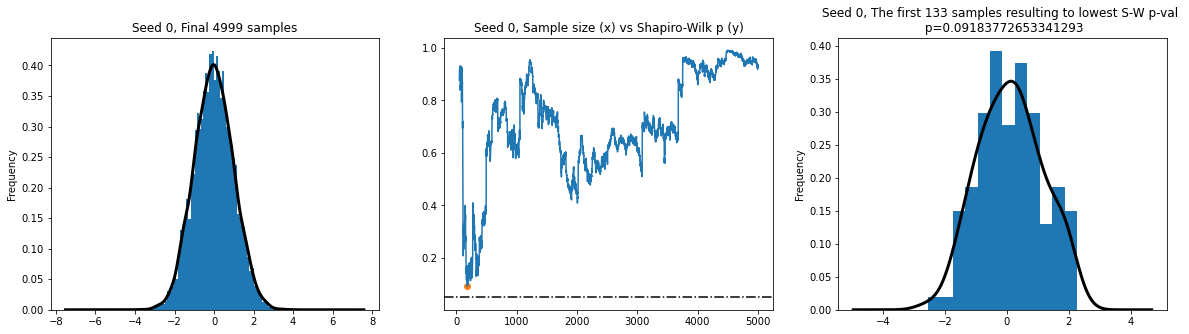

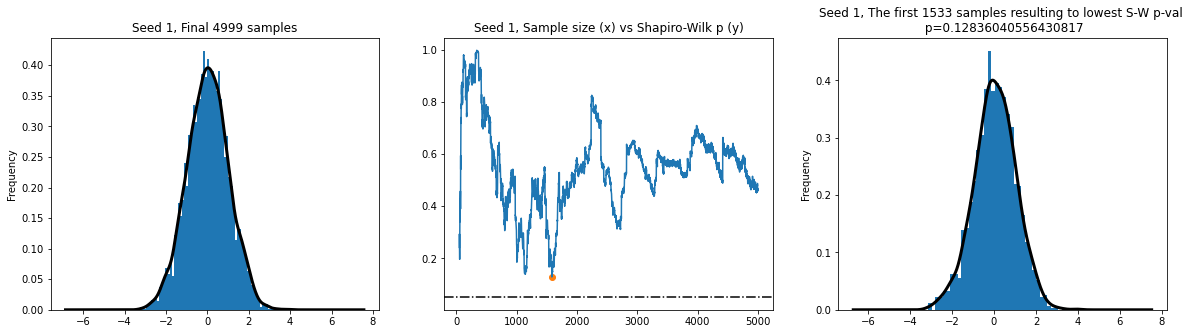

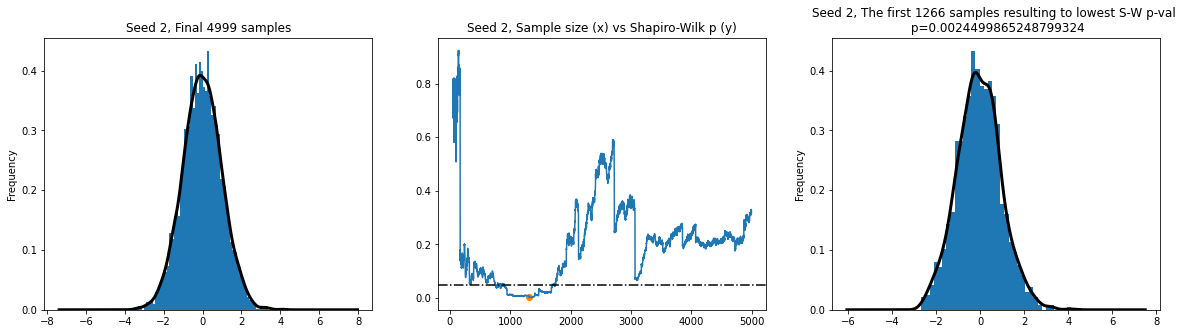

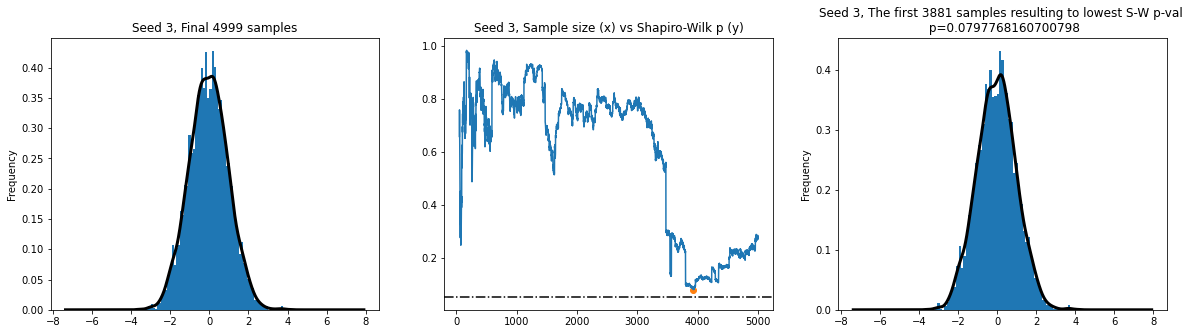

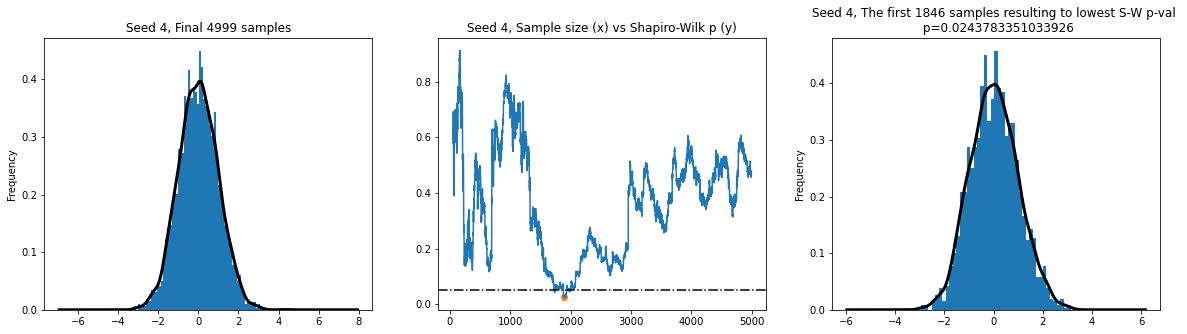

In [18]:
plt.rcParams["figure.figsize"]=(20,5)

N = 4999  # (and max sample size)
iters = 5  # how many different times different plot is plotted, i.e., how many different comparisons of normal distributions there will be
min_sample_size = 50  # the sample size where the SW-test is performed for the 1st time.

for s in range(iters):  # s = seed; seeds: [0,iters)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3)
    np.random.seed(s)

    # Create a sample of normally distributed values with size N
    norm_distr = pd.Series(stats.norm.rvs(size=N))

    # Normal histogram of the N values
    norm_distr.plot.kde(ax=ax1, c="k", lw=3)
    norm_distr.plot.hist(density=True, ax=ax1, bins=np.ceil(np.sqrt(N)).astype(int))

    # Shapiro-Wilk test in SciPy yields a p-value for whther the data is supposedly normal or not, the closer to 0, the less likely it is normal
    # An empty numpy array with (N-min_sample_size) rows and 2 columns(for the data set size and the p-value)
    sw_test_results = np.empty((norm_distr.size - min_sample_size, 2))
    for i in range(min_sample_size, norm_distr.size):
        #sample_x = np.random.choice(norm_distr,i)
        sample_x = norm_distr[0:i]  # Take the first i values to the sample, it's 10 during the first run
        sw_test_results[i-min_sample_size] = (i, stats.shapiro(sample_x/np.std(sample_x))[1])
    
    # Let's find the smallest value to plot the histogram in the "least normal distr. state"
    min_p_val = min(sw_test_results[:,1])
    min_p_val_index = np.argmin(sw_test_results[:,1])

    ax2.plot(sw_test_results[:,0],sw_test_results[:,1])
    ax2.axhline(y=0.05, color='k', linestyle='-.')  # the 95% CI
    norm_distr[0:min_p_val_index].plot.kde(ax=ax3, c="k", lw=3)
    norm_distr[0:min_p_val_index].plot.hist(density=True, ax=ax3, bins=np.ceil(np.sqrt(min_p_val_index)).astype(int))
    
    ax2.scatter(min_p_val_index+min_sample_size, min_p_val, marker="o", c="C1")
    
    ax1.set_title(f"Seed {s}, Final {N} samples")
    ax2.set_title(f"Seed {s}, Sample size (x) vs Shapiro-Wilk p (y)")
    ax3.set_title(f"Seed {s}, The first {min_p_val_index} samples resulting to lowest S-W p-val \n p={min_p_val}")
    
    
    plt.show()

This sure isn't a mathematical proof of anything, but it does show that SW-test can give "false" results, even with generated normally distributed data, although quite rarely.

While the data generated in Arma *should* technically follow a mathematic distribution, as it must be programmed to do so, at the very least to a certain extent, this gives me enough confirmation that using SW-test to confirm the normality of data isn't necessary in a case like this, when the whole point is only to get a general understanding of the data.